Second part of laboratories were conducted by <a href="https://github.com/jarek-pawlowski">Jarosław Pawłowski</a>. He created notebooks we used in laboratories. I am really glad that I had him as a tutor.

In second course of ML/AI we were build ML models using pytorch.

In this notebook I will present only some task we had as a homework from notebook.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

from torchsummary import summary

from functools import partial
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

model_args = {}
model_args['batch_size'] = 128

# learning rate is how fast it will descend
model_args['lr'] = 1.e-3
# the number of epochs is the number of times you go through the full dataset
model_args['epochs'] = 40

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0
Device: cuda:0


In [2]:
# define scaled-dot product
def scaled_dot_product(q, k, v):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / np.sqrt(d_k)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [3]:
# define multi-head attention block
class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads):
        """
            Assumptions we made:
            d_k = d_v = head_dim
            num_heads*head_dim = embed_dim
            d_out = embed_dim
            D = d_model = input_dim
        """
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        # Stack all weight matrices 1...h together for efficiency
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, return_attention=False):
        batch_size, seq_length, _ = x.size()
        qkv = self.qkv_proj(x) # [batch_size, seq_length, 3*embed_dim]

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)  # [batch_size, seq_length, num_heads, 3*head_dim]
        qkv = qkv.permute(0, 2, 1, 3) # [batch_size, num_heads, seq_length, 3*head_dim]
        q, k, v = qkv.chunk(3, dim=-1) # [batch_size, num_heads, seq_length, head_dim]

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v)
        values = values.permute(0, 2, 1, 3) # [batch_size, seq_length, num_heads, head_dim]
        values = values.reshape(batch_size, seq_length, self.embed_dim) # heads concatenation
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o

In [4]:
class EncoderBlock(nn.Module):

    def __init__(self, input_dim, num_heads, dim_feedforward):
        """
            input_dim - dimensionality of the input
            num_heads - number of heads to use in the attention block
            dim_feedforward - dimensionality of the hidden layer in the MLP
            For simplicity we assume input_dim = embed_dim
        """
        super().__init__()

        # Attention layer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)

        # Two-layer MLP
        self.MLP_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)

    def forward(self, x):
        # Attention part
        attn_out = self.self_attn(x)
        x = x + attn_out  # residual connection
        x = self.norm1(x)

        # MLP part
        linear_out = self.MLP_net(x)
        x = x + linear_out  # residual connection
        x = self.norm2(x)

        return x

class TransformerEncoder(nn.Module):

    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for l in self.layers:
            x = l(x)
        return x

    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, return_attention=True)
            attention_maps.append(attn_map)
            x = l(x)
        return attention_maps

In [5]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        """
            d_model - input dim
            max_len - maximum length of a sequence to expect
            Encoding same as in the original paper
        """
        super().__init__()

        # create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

In [6]:
class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):

    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

In [7]:
class TransformerModel(nn.Module):

    def __init__(self, input_dim, num_heads, num_layers):
        """
        Inputs:
            input_dim = model_dim - dimensionality to use inside the Transformer
            num_heads - number of heads to use in the Multi-Head Attention blocks
            num_layers - number of encoder blocks to use
            lr - learning rate in the optimizer
            warmup - number of warmup steps
            max_iters - number of maximum iterations the model is trained for
        """
        super().__init__()
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(d_model=self.input_dim)
        # Transformer
        self.transformer = TransformerEncoder(num_layers=self.num_layers,
                                              input_dim=self.input_dim,
                                              num_heads=self.num_heads,
                                              dim_feedforward=2*self.input_dim)

    def forward(self, x, add_positional_encoding=True):
        """
            x - input features of shape [Batch, SeqLen, input_dim]
        """
        if add_positional_encoding:
            x = self.positional_encoding(x)
        x = self.transformer(x)
        return x

    @torch.no_grad()
    def get_attention_maps(self, x, add_positional_encoding=True):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        if add_positional_encoding:
            x = self.positional_encoding(x)
        attention_maps = self.transformer.get_attention_maps(x)
        return attention_maps


class TrainingUtils():

    def __init__(self, device, model, num_classes, add_positional_encoding):
        self.model = model.to(device)
        self.num_classes = num_classes
        self.positional_encoding = add_positional_encoding

    def define_optimizer(self, lr, warmup, max_iters, use_lr_scheduler=True):
        self.optimizer = optim.Adam(model.parameters(), lr=lr)
        if use_lr_scheduler:
            self.lr_scheduler = CosineWarmupScheduler(self.optimizer, warmup=warmup, max_iters=max_iters)
        else:
            self.lr_scheduler = None

    def _calculate_loss(self, batch):
        # get data and transform categories to one-hot vectors
        inp_data, labels = batch
        inp_data = F.one_hot(inp_data, num_classes=self.num_classes).float().to(device)
        labels = labels.to(device)
        # perform prediction and calculate loss and accuracy
        preds = self.model(inp_data, add_positional_encoding=self.positional_encoding)
        loss = F.cross_entropy(preds.view(-1,preds.size(-1)), labels.view(-1))
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        return loss, acc

    def _step(self, batch):
        loss, _ = self._calculate_loss(batch)
        return loss

    def train(self, train_loader, epoch_idx):
        self.model.train()
        train_loss = 0.
        # get subsequent batches over the data in a given epoch
        for batch_idx, batch in enumerate(train_loader):
            self.optimizer.zero_grad()
            loss = self._step(batch)
            loss.backward()
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step(batch_idx + epoch_idx*len(train_loader))

            #print(self.lr_scheduler.get_last_lr())
            train_loss += loss.item()
        return train_loss/len(train_loader)

    def validate(self, val_loader, epoch_idx):
        self.model.eval()
        val_loss = 0.
        val_acc = 0.
        # get subsequent batches over the data in a given epoch
        for batch_idx, batch in enumerate(val_loader):
            loss, acc = self._calculate_loss(batch)
            val_loss  += loss.item()
            val_acc  += acc.item()
        return val_loss/len(val_loader), val_acc/len(val_loader)

    def plot_loss(self, train_losses, val_losses, title=None):
        plt.grid(True)
        plt.xlabel("subsequent epochs")
        plt.ylabel('loss')
        xlabels = np.linspace(0, model_args['epochs'], num=len(train_losses), endpoint=True)
        plt.plot(xlabels, train_losses, label='training')
        plt.plot(xlabels, val_losses, label='validation')
        plt.legend()
        if title is not None: plt.title(title)
        plt.show()



In [8]:
class ReverseDataset(data.Dataset):

    def __init__(self, num_categories, seq_len, size):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size

        self.data = torch.randint(self.num_categories, size=(self.size, self.seq_len))

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        labels = torch.flip(inp_data, dims=(0,))
        return inp_data, labels

In [9]:
dataset = partial(ReverseDataset, 10, 16)
train_loader = data.DataLoader(dataset(50000), batch_size=model_args['batch_size'],
                               shuffle=True, drop_last=True, pin_memory=True)
val_loader   = data.DataLoader(dataset(5000), batch_size=model_args['batch_size'])
test_loader  = data.DataLoader(dataset(10000), batch_size=model_args['batch_size'])

inp_data, labels = train_loader.dataset[0]
print("Input data:", inp_data)
print("Labels:    ", labels)

Input data: tensor([4, 0, 9, 4, 2, 1, 4, 6, 0, 1, 9, 9, 4, 2, 1, 6])
Labels:     tensor([6, 1, 2, 4, 9, 9, 1, 0, 6, 4, 1, 2, 4, 9, 0, 4])


In [10]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
    fig.subplots_adjust(hspace=0.5)
    plt.show()
data_input, labels = next(iter(val_loader))


## Tasks to do
* try to optimize the model hyperparameters (e.g. no. of layers, no. of heads within the layers), **it may be necessary to restart training several times**;
* please play with different ingrediends of the Transformer model, e.g. turn-off positional encoding, or residual connections in the *EncoderBlock*, or use standard *lr_scheduler* (i.e. without warming-up);
* please change the problem to learning a dataset with 0-9 digits in random order that we want to translate to sorted series (i.e. train the Transformer to learn sorting) -- please plot the attension map in that case -- do we have any understanding of this?

In [11]:
train_loader.dataset.num_categories

10

In [12]:
model = TransformerModel(input_dim=train_loader.dataset.num_categories,
                         num_heads=2,
                         num_layers=3).to(device)
summary(model, input_size=(16,10))

utils = TrainingUtils(device=device,
                      model=model,
                      num_classes=train_loader.dataset.num_categories,
                      add_positional_encoding=True)
utils.define_optimizer(lr=model_args['lr'],
                       warmup=500,
                       max_iters=model_args['epochs']*len(train_loader))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
PositionalEncoding-1               [-1, 16, 10]               0
            Linear-2               [-1, 16, 30]             330
            Linear-3               [-1, 16, 10]             110
MultiheadAttention-4               [-1, 16, 10]               0
         LayerNorm-5               [-1, 16, 10]              20
            Linear-6               [-1, 16, 20]             220
              ReLU-7               [-1, 16, 20]               0
            Linear-8               [-1, 16, 10]             210
         LayerNorm-9               [-1, 16, 10]              20
     EncoderBlock-10               [-1, 16, 10]               0
           Linear-11               [-1, 16, 30]             330
           Linear-12               [-1, 16, 10]             110
MultiheadAttention-13               [-1, 16, 10]               0
        LayerNorm-14               [-1

C:\Users\Michal\PycharmProjects\ecg_class\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch 1 | training loss = 2.5767 | validation loss = 2.4575 | validation acc 0.1102
Train Epoch 2 | training loss = 2.2583 | validation loss = 1.7956 | validation acc 0.3968
Train Epoch 3 | training loss = 1.1774 | validation loss = 0.8258 | validation acc 0.8004
Train Epoch 4 | training loss = 0.6880 | validation loss = 0.5832 | validation acc 0.8598
Train Epoch 5 | training loss = 0.5260 | validation loss = 0.4748 | validation acc 0.8816
Train Epoch 6 | training loss = 0.4368 | validation loss = 0.4051 | validation acc 0.8904
Train Epoch 7 | training loss = 0.3724 | validation loss = 0.3523 | validation acc 0.8993
Train Epoch 8 | training loss = 0.3248 | validation loss = 0.3010 | validation acc 0.9113
Train Epoch 9 | training loss = 0.2826 | validation loss = 0.2642 | validation acc 0.9198
Train Epoch 10 | training loss = 0.2489 | validation loss = 0.2384 | validation acc 0.9267
Train Epoch 11 | training loss = 0.2257 | validation loss = 0.2142 | validation acc 0.9318
Train Ep

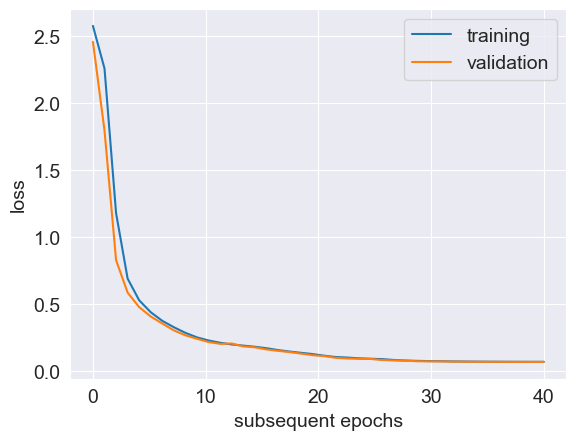

In [13]:
train_losses = []
validation_losses = []
for epoch_idx in range(model_args['epochs']):
    train_loss = utils.train(train_loader, epoch_idx)
    val_loss, val_acc = utils.validate(val_loader, epoch_idx)
    print('Train Epoch {} | training loss = {:.4f} | validation loss = {:.4f} | validation acc {:.4f}'.
          format(epoch_idx+1, train_loss, val_loss, val_acc))
    train_losses.append(train_loss)
    validation_losses.append(val_loss)

utils.plot_loss(train_losses, validation_losses)

In [14]:
attention_maps = model.get_attention_maps(inp_data, True)
plot_attention_maps(data_input, attention_maps, idx=0)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

## 2. +++++++++++++++++++++++++++++++++++++++++++++++

In [ ]:
model = TransformerModel(input_dim=train_loader.dataset.num_categories,
                         num_heads=2,
                         num_layers=3).to(device)
summary(model, input_size=(16,10))

utils = TrainingUtils(device=device,
                      model=model,
                      num_classes=train_loader.dataset.num_categories,
                      add_positional_encoding=False)
utils.define_optimizer(lr=model_args['lr'],
                       warmup=500,
                       max_iters=model_args['epochs']*len(train_loader))

In [ ]:
train_losses = []
validation_losses = []
for epoch_idx in range(model_args['epochs']):
    train_loss = utils.train(train_loader, epoch_idx)
    val_loss, val_acc = utils.validate(val_loader, epoch_idx)
    print('Train Epoch {} | training loss = {:.4f} | validation loss = {:.4f} | validation acc {:.4f}'.
          format(epoch_idx+1, train_loss, val_loss, val_acc))
    train_losses.append(train_loss)
    validation_losses.append(val_loss)

utils.plot_loss(train_losses, validation_losses)

In [ ]:
attention_maps = model.get_attention_maps(inp_data, False)
plot_attention_maps(data_input, attention_maps, idx=0)

not using learning rate scheduler

In [ ]:
model = TransformerModel(input_dim=train_loader.dataset.num_categories,
                         num_heads=2,
                         num_layers=3).to(device)
summary(model, input_size=(16,10))

utils = TrainingUtils(device=device,
                      model=model,
                      num_classes=train_loader.dataset.num_categories,
                      add_positional_encoding=True)
utils.define_optimizer(lr=model_args['lr'],
                       warmup=500,
                       max_iters=model_args['epochs']*len(train_loader), use_lr_scheduler=False)

In [ ]:
train_losses = []
validation_losses = []
for epoch_idx in range(model_args['epochs']):
    train_loss = utils.train(train_loader, epoch_idx)
    val_loss, val_acc = utils.validate(val_loader, epoch_idx)
    print('Train Epoch {} | training loss = {:.4f} | validation loss = {:.4f} | validation acc {:.4f}'.
    format(epoch_idx + 1, train_loss, val_loss, val_acc))
    train_losses.append(train_loss)
    validation_losses.append(val_loss)

utils.plot_loss(train_losses, validation_losses)

In [ ]:
attention_maps = model.get_attention_maps(inp_data, False)
plot_attention_maps(data_input, attention_maps, idx=0)

## 3. +++++++++++++++++++++++++++++++++++++++++++++++

In [ ]:
class SortDataset(data.Dataset):

    def __init__(self, num_categories, seq_len, size):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size

        self.data = torch.randint(self.num_categories, size=(self.size, self.seq_len))

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        sort, _ = torch.sort(inp_data)
        return inp_data, sort

In [ ]:
dataset = partial(SortDataset, 10, 16)
train_loader = data.DataLoader(dataset(50000), batch_size=model_args['batch_size'],
                               shuffle=True, drop_last=True, pin_memory=True)
val_loader   = data.DataLoader(dataset(5000), batch_size=model_args['batch_size'], shuffle=True, drop_last=True, pin_memory=True)
test_loader  = data.DataLoader(dataset(10000), batch_size=model_args['batch_size'], shuffle=True, drop_last=True, pin_memory=True)

inp_data, labels = train_loader.dataset[0]
print("Input data:", inp_data)
print("Labels:    ", labels)

In [ ]:
model = TransformerModel(input_dim=train_loader.dataset.num_categories,
                         num_heads=1,
                         num_layers=1).to(device)
summary(model, input_size=(16,10))

utils = TrainingUtils(device=device,
                      model=model,
                      num_classes=train_loader.dataset.num_categories, add_positional_encoding=True)
utils.define_optimizer(lr=model_args['lr'],
                       warmup=500,
                       max_iters=model_args['epochs']*len(train_loader))

In [ ]:
train_losses = []
validation_losses = []
for epoch_idx in range(model_args['epochs']):
    train_loss = utils.train(train_loader, epoch_idx)
    val_loss, val_acc = utils.validate(val_loader, epoch_idx)
    print('Train Epoch {} | training loss = {:.4f} | validation loss = {:.4f} | validation acc {:.4f}'.
          format(epoch_idx+1, train_loss, val_loss, val_acc))
    train_losses.append(train_loss)
    validation_losses.append(val_loss)

utils.plot_loss(train_losses, validation_losses)

Bigger model

In [ ]:
model = TransformerModel(input_dim=train_loader.dataset.num_categories,
                         num_heads=2,
                         num_layers=3).to(device)
summary(model, input_size=(16,10))

utils = TrainingUtils(device=device,
                      model=model,
                      num_classes=train_loader.dataset.num_categories, add_positional_encoding=True)
utils.define_optimizer(lr=model_args['lr'],
                       warmup=500,
                       max_iters=model_args['epochs']*len(train_loader))

In [ ]:
train_losses = []
validation_losses = []
for epoch_idx in range(model_args['epochs']):
    train_loss = utils.train(train_loader, epoch_idx)
    val_loss, val_acc = utils.validate(val_loader, epoch_idx)
    print('Train Epoch {} | training loss = {:.4f} | validation loss = {:.4f} | validation acc {:.4f}'.
          format(epoch_idx+1, train_loss, val_loss, val_acc))
    train_losses.append(train_loss)
    validation_losses.append(val_loss)

utils.plot_loss(train_losses, validation_losses)

In [ ]:
model.eval()
data_input, labels = next(iter(val_loader))
inp_data = F.one_hot(data_input, num_classes=val_loader.dataset.num_categories).float()
inp_data = inp_data.to(device)
attention_maps = model.get_attention_maps(inp_data)
plot_attention_maps(data_input, attention_maps, idx=0)

without learning rate sheduler

In [ ]:
model = TransformerModel(input_dim=train_loader.dataset.num_categories,
                         num_heads=2,
                         num_layers=3).to(device)
summary(model, input_size=(16,10))

utils = TrainingUtils(device=device,
                      model=model,
                      num_classes=train_loader.dataset.num_categories,
                      add_positional_encoding=True)
utils.define_optimizer(lr=model_args['lr'],
                       warmup=500,
                       max_iters=model_args['epochs']*len(train_loader), use_lr_scheduler=False)

In [ ]:
train_losses = []
validation_losses = []
for epoch_idx in range(model_args['epochs']):
    train_loss = utils.train(train_loader, epoch_idx)
    val_loss, val_acc = utils.validate(val_loader, epoch_idx)
    print('Train Epoch {} | training loss = {:.4f} | validation loss = {:.4f} | validation acc {:.4f}'.
    format(epoch_idx + 1, train_loss, val_loss, val_acc))
    train_losses.append(train_loss)
    validation_losses.append(val_loss)

utils.plot_loss(train_losses, validation_losses)

In [ ]:
model.eval()
data_input, labels = next(iter(val_loader))
inp_data = F.one_hot(data_input, num_classes=val_loader.dataset.num_categories).float()
inp_data = inp_data.to(device)
attention_maps = model.get_attention_maps(inp_data)
plot_attention_maps(data_input, attention_maps, idx=0)

One more layer

In [ ]:
model = TransformerModel(input_dim=train_loader.dataset.num_categories,
                         num_heads=2,
                         num_layers=4).to(device)
summary(model, input_size=(16,10))

utils = TrainingUtils(device=device,
                      model=model,
                      num_classes=train_loader.dataset.num_categories,
                      add_positional_encoding=True)
utils.define_optimizer(lr=model_args['lr'],
                       warmup=500,
                       max_iters=model_args['epochs']*len(train_loader), use_lr_scheduler=False)

In [ ]:
train_losses = []
validation_losses = []
for epoch_idx in range(model_args['epochs']):
    train_loss = utils.train(train_loader, epoch_idx)
    val_loss, val_acc = utils.validate(val_loader, epoch_idx)
    print('Train Epoch {} | training loss = {:.4f} | validation loss = {:.4f} | validation acc {:.4f}'.
    format(epoch_idx + 1, train_loss, val_loss, val_acc))
    train_losses.append(train_loss)
    validation_losses.append(val_loss)

utils.plot_loss(train_losses, validation_losses)

In [ ]:
model.eval()
data_input, labels = next(iter(val_loader))
inp_data = F.one_hot(data_input, num_classes=val_loader.dataset.num_categories).float()
inp_data = inp_data.to(device)
attention_maps = model.get_attention_maps(inp_data)
plot_attention_maps(data_input, attention_maps, idx=0)

MORE LAYERS

In [ ]:
model = TransformerModel(input_dim=train_loader.dataset.num_categories,
                         num_heads=2,
                         num_layers=5).to(device)
summary(model, input_size=(16,10))

utils = TrainingUtils(device=device,
                      model=model,
                      num_classes=train_loader.dataset.num_categories,
                      add_positional_encoding=True)
utils.define_optimizer(lr=model_args['lr'],
                       warmup=500,
                       max_iters=model_args['epochs']*len(train_loader), use_lr_scheduler=False)

In [ ]:
train_losses = []
validation_losses = []
for epoch_idx in range(model_args['epochs']):
    train_loss = utils.train(train_loader, epoch_idx)
    val_loss, val_acc = utils.validate(val_loader, epoch_idx)
    print('Train Epoch {} | training loss = {:.4f} | validation loss = {:.4f} | validation acc {:.4f}'.
    format(epoch_idx + 1, train_loss, val_loss, val_acc))
    train_losses.append(train_loss)
    validation_losses.append(val_loss)

utils.plot_loss(train_losses, validation_losses)

In [ ]:
model.eval()
data_input, labels = next(iter(val_loader))
inp_data = F.one_hot(data_input, num_classes=val_loader.dataset.num_categories).float()
inp_data = inp_data.to(device)
attention_maps = model.get_attention_maps(inp_data)
plot_attention_maps(data_input, attention_maps, idx=0)

More heads

In [ ]:
model = TransformerModel(input_dim=train_loader.dataset.num_categories,
                         num_heads=5,
                         num_layers=5).to(device)
summary(model, input_size=(16,10))

utils = TrainingUtils(device=device,
                      model=model,
                      num_classes=train_loader.dataset.num_categories,
                      add_positional_encoding=True)
utils.define_optimizer(lr=model_args['lr'],
                       warmup=500,
                       max_iters=model_args['epochs']*len(train_loader), use_lr_scheduler=False)

In [ ]:
train_losses = []
validation_losses = []
for epoch_idx in range(model_args['epochs']):
    train_loss = utils.train(train_loader, epoch_idx)
    val_loss, val_acc = utils.validate(val_loader, epoch_idx)
    print('Train Epoch {} | training loss = {:.4f} | validation loss = {:.4f} | validation acc {:.4f}'.
    format(epoch_idx + 1, train_loss, val_loss, val_acc))
    train_losses.append(train_loss)
    validation_losses.append(val_loss)

utils.plot_loss(train_losses, validation_losses)

MORE HEADS

In [ ]:
model = TransformerModel(input_dim=train_loader.dataset.num_categories,
                         num_heads=10,
                         num_layers=5).to(device)
summary(model, input_size=(16,10))

utils = TrainingUtils(device=device,
                      model=model,
                      num_classes=train_loader.dataset.num_categories,
                      add_positional_encoding=True)
utils.define_optimizer(lr=model_args['lr'],
                       warmup=500,
                       max_iters=model_args['epochs']*len(train_loader), use_lr_scheduler=False)

In [ ]:
train_losses = []
validation_losses = []
for epoch_idx in range(model_args['epochs']):
    train_loss = utils.train(train_loader, epoch_idx)
    val_loss, val_acc = utils.validate(val_loader, epoch_idx)
    print('Train Epoch {} | training loss = {:.4f} | validation loss = {:.4f} | validation acc {:.4f}'.
    format(epoch_idx + 1, train_loss, val_loss, val_acc))
    train_losses.append(train_loss)
    validation_losses.append(val_loss)

utils.plot_loss(train_losses, validation_losses)

In [ ]:
model.eval()
data_input, labels = next(iter(val_loader))
inp_data = F.one_hot(data_input, num_classes=val_loader.dataset.num_categories).float()
inp_data = inp_data.to(device)
attention_maps = model.get_attention_maps(inp_data)
plot_attention_maps(data_input, attention_maps, idx=0)